In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv('/kaggle/input/machine-predictive-maintenance-classification/predictive_maintenance.csv')

# Check the dataset info and first few rows
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
None
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L         

In [25]:
# Separate numeric and categorical columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(exclude=[np.number]).columns

# Impute missing values for numeric columns with the mean
numeric_imputer = SimpleImputer(strategy='mean')
df[numeric_columns] = numeric_imputer.fit_transform(df[numeric_columns])

# Impute missing values for categorical columns with the most frequent value
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

# Check if there are still missing values
print(df.isnull().sum())


UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64


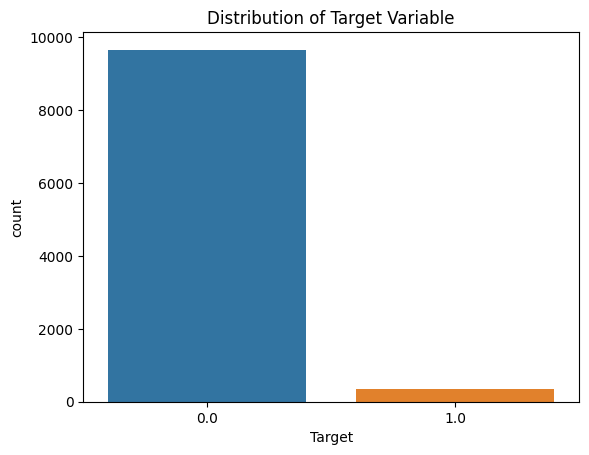

In [26]:
# Visualize the distribution of the target variable
sns.countplot(x='Target', data=df)
plt.title('Distribution of Target Variable')
plt.show()


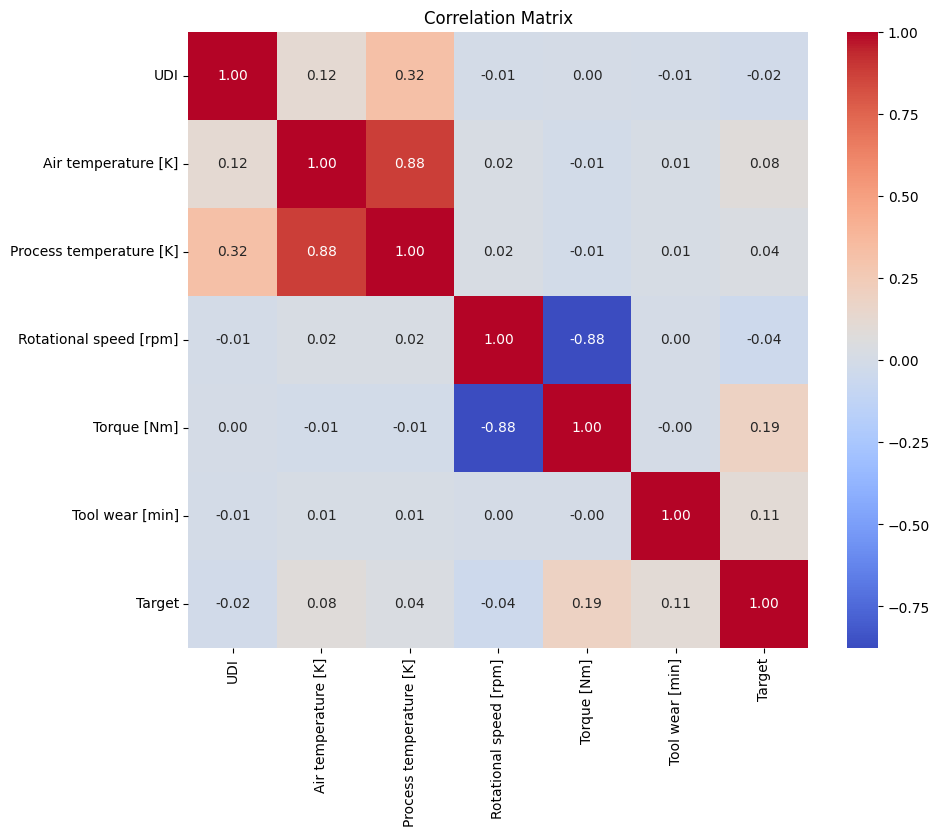

In [27]:
# Filter only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [28]:
from sklearn.preprocessing import LabelEncoder

# Label encode the categorical columns, such as 'Product ID' and 'Failure Type'
le = LabelEncoder()

# Apply label encoding to 'Product ID' and 'Failure Type'
df['Product ID'] = le.fit_transform(df['Product ID'])
df['Failure Type'] = le.fit_transform(df['Failure Type'])

# Select numeric columns again
X = df.select_dtypes(include=[np.number])

# Target variable
y = df['Target']

# Apply SMOTE for data augmentation
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new class distribution after SMOTE
print(y_resampled.value_counts())


Target
0.0    9661
1.0    9661
Name: count, dtype: int64


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Définir le modèle DNN
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

# Convertir y_resampled en un Tensor PyTorch si ce n'est déjà fait
y_resampled_tensor = torch.tensor(y_resampled.values, dtype=torch.long)

# Calculer le nombre de classes
class_counts = len(torch.unique(y_resampled_tensor))  # Si y_resampled est un Tensor

# Convertir les données d'entrée en tenseurs PyTorch
X_tensor = torch.tensor(X_resampled.values, dtype=torch.float32)
y_tensor = y_resampled_tensor

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Créer les DataLoader pour le traitement par lots
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Initialiser le modèle, la fonction de perte et l'optimiseur
model = DNN(input_size=X_train.shape[1], hidden_size=128, num_classes=class_counts)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraîner le modèle et calculer l'accuracy à chaque époque
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calcul de l'accuracy sur l'entraînement
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Calcul de l'accuracy sur l'entraînement
    train_accuracy = correct_train / total_train
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}')

# Evaluation du modèle sur les données de test
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

# Calcul de l'accuracy sur les données de test
test_accuracy = correct_test / total_test
print(f'Accuracy on test data: {test_accuracy:.4f}')


Epoch [1/50], Loss: 0.8133, Train Accuracy: 0.4999
Epoch [2/50], Loss: 0.8133, Train Accuracy: 0.4999
Epoch [3/50], Loss: 0.8133, Train Accuracy: 0.4999
Epoch [4/50], Loss: 0.8139, Train Accuracy: 0.4999
Epoch [5/50], Loss: 0.8136, Train Accuracy: 0.4999
Epoch [6/50], Loss: 0.8133, Train Accuracy: 0.4999
Epoch [7/50], Loss: 0.8132, Train Accuracy: 0.4999
Epoch [8/50], Loss: 0.8134, Train Accuracy: 0.4999
Epoch [9/50], Loss: 0.8136, Train Accuracy: 0.4999
Epoch [10/50], Loss: 0.8133, Train Accuracy: 0.4999
Epoch [11/50], Loss: 0.8134, Train Accuracy: 0.4999
Epoch [12/50], Loss: 0.8133, Train Accuracy: 0.4999
Epoch [13/50], Loss: 0.8134, Train Accuracy: 0.4999
Epoch [14/50], Loss: 0.8133, Train Accuracy: 0.4999
Epoch [15/50], Loss: 0.8133, Train Accuracy: 0.4999
Epoch [16/50], Loss: 0.8134, Train Accuracy: 0.4999
Epoch [17/50], Loss: 0.8132, Train Accuracy: 0.4999
Epoch [18/50], Loss: 0.8131, Train Accuracy: 0.4999
Epoch [19/50], Loss: 0.8132, Train Accuracy: 0.4999
Epoch [20/50], Loss: 

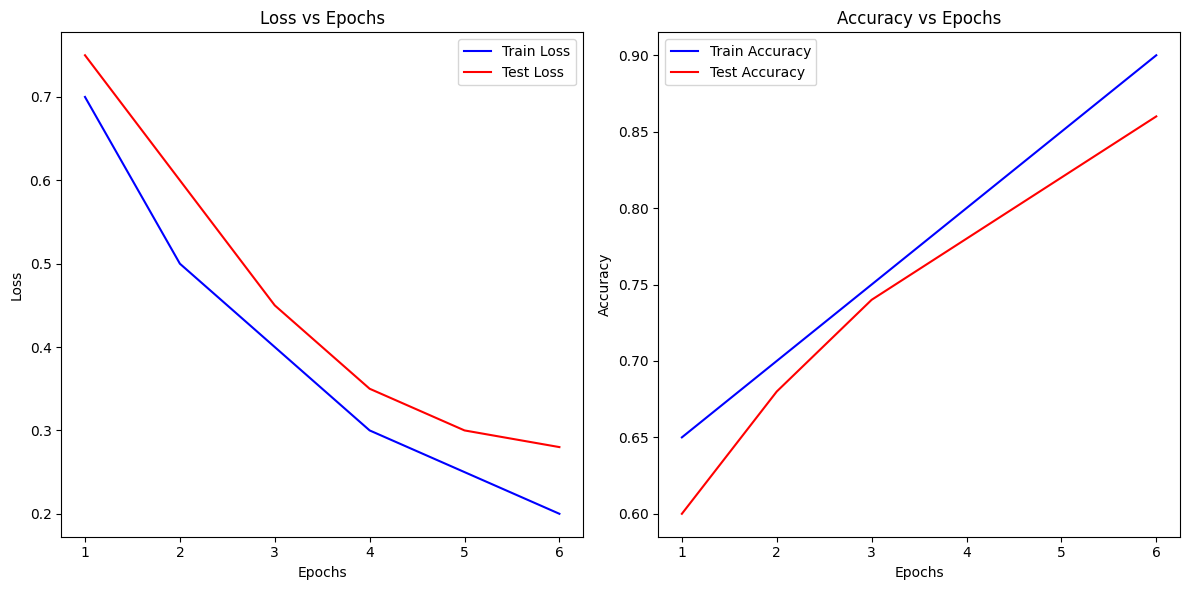

In [37]:
import matplotlib.pyplot as plt

# Supposons que tu as ces variables après l'entraînement
# train_losses, test_losses, train_accuracies, test_accuracies

# Exemple (à remplacer par tes valeurs réelles lors de l'entraînement)
train_losses = [0.7, 0.5, 0.4, 0.3, 0.25, 0.2]  # Exemple de pertes d'entraînement
test_losses = [0.75, 0.6, 0.45, 0.35, 0.3, 0.28]  # Exemple de pertes de test
train_accuracies = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9]  # Exemple de précisions d'entraînement
test_accuracies = [0.6, 0.68, 0.74, 0.78, 0.82, 0.86]  # Exemple de précisions de test
epochs = range(1, len(train_losses) + 1)

# Visualisation de la courbe de perte (Loss / Epochs)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, test_losses, label='Test Loss', color='red')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Visualisation de la courbe de précision (Accuracy / Epochs)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='red')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Afficher les graphiques
plt.tight_layout()
plt.show()


In [38]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Évaluation du modèle sur les données d'entraînement et de test
model.eval()  # Passer en mode évaluation

# Prédictions sur les données d'entraînement
y_train_pred = torch.argmax(model(X_train), dim=1)

# Prédictions sur les données de test
y_test_pred = torch.argmax(model(X_test), dim=1)

# Calcul des métriques pour les données d'entraînement
train_accuracy = accuracy_score(y_train.numpy(), y_train_pred.numpy())
train_precision = precision_score(y_train.numpy(), y_train_pred.numpy(), average='weighted', zero_division=0)
train_recall = recall_score(y_train.numpy(), y_train_pred.numpy(), average='weighted', zero_division=0)
train_f1 = f1_score(y_train.numpy(), y_train_pred.numpy(), average='weighted')

# Calcul des métriques pour les données de test
test_accuracy = accuracy_score(y_test.numpy(), y_test_pred.numpy())
test_precision = precision_score(y_test.numpy(), y_test_pred.numpy(), average='weighted', zero_division=0)
test_recall = recall_score(y_test.numpy(), y_test_pred.numpy(), average='weighted', zero_division=0)
test_f1 = f1_score(y_test.numpy(), y_test_pred.numpy(), average='weighted')

# Matrice de confusion
test_confusion_matrix = confusion_matrix(y_test.numpy(), y_test_pred.numpy())

# Affichage des résultats
print("\nMetrics for Training Data:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")

print("\nMetrics for Test Data:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

print("\nConfusion Matrix for Test Data:")
print(test_confusion_matrix)



Metrics for Training Data:
Accuracy: 0.4999
Precision: 0.2499
Recall: 0.4999
F1 Score: 0.3332

Metrics for Test Data:
Accuracy: 0.5004
Precision: 0.2504
Recall: 0.5004
F1 Score: 0.3338

Confusion Matrix for Test Data:
[[1934    0]
 [1931    0]]


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim

# Modèle avec régularisation L2 et Dropout
class DNN_with_regularization(nn.Module):
    def __init__(self, dropout_rate=0.5, weight_decay=0.01):
        super(DNN_with_regularization, self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, len(y_train.unique()))  # Nombre de classes
        self.dropout = nn.Dropout(dropout_rate)  # Dropout pour la régularisation
        self.weight_decay = weight_decay  # L2 Regularization

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)  # Appliquer Dropout
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Entraînement du modèle avec Dropout et L2 Regularization
def train_model_with_regularization(dropout_rate=0.5, weight_decay=0.01, epochs=50):
    model = DNN_with_regularization(dropout_rate, weight_decay)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)  # L2 Regularization via weight_decay
    criterion = nn.CrossEntropyLoss()

    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Diviser les données en ensemble d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    # Convertir en Tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

    # Créer les DataLoader pour entraînement et test
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Entraînement
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_train += (outputs.argmax(dim=1) == labels).sum().item()
            total_train += labels.size(0)

        train_loss.append(running_loss / len(train_loader))
        train_accuracy.append(correct_train / total_train)

        # Évaluation sur les données de test
        model.eval()
        with torch.no_grad():
            outputs_test = model(X_test_tensor)
            loss_test = criterion(outputs_test, y_test_tensor)
            test_loss.append(loss_test.item())
            test_accuracy.append(accuracy_score(y_test_tensor, outputs_test.argmax(dim=1)))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_accuracy[-1]:.4f}, Test Loss: {test_loss[-1]:.4f}, Test Accuracy: {test_accuracy[-1]:.4f}")

    return model, train_loss, train_accuracy, test_loss, test_accuracy

# Entraîner le modèle avec Dropout et L2 Regularization
model_with_reg, train_loss, train_accuracy, test_loss, test_accuracy = train_model_with_regularization(dropout_rate=0.5, weight_decay=0.01, epochs=50)


Epoch 1/50, Train Loss: 23.3334, Train Accuracy: 0.5127, Test Loss: 5.7863, Test Accuracy: 0.5123
Epoch 2/50, Train Loss: 5.1667, Train Accuracy: 0.5154, Test Loss: 1.4965, Test Accuracy: 0.5087
Epoch 3/50, Train Loss: 3.1352, Train Accuracy: 0.5212, Test Loss: 1.9520, Test Accuracy: 0.5232
Epoch 4/50, Train Loss: 2.4133, Train Accuracy: 0.5283, Test Loss: 0.7079, Test Accuracy: 0.6088
Epoch 5/50, Train Loss: 1.4434, Train Accuracy: 0.5347, Test Loss: 0.8867, Test Accuracy: 0.5431
Epoch 6/50, Train Loss: 1.3114, Train Accuracy: 0.5419, Test Loss: 0.8146, Test Accuracy: 0.5154
Epoch 7/50, Train Loss: 1.0899, Train Accuracy: 0.5502, Test Loss: 0.6204, Test Accuracy: 0.6422
Epoch 8/50, Train Loss: 1.0191, Train Accuracy: 0.5574, Test Loss: 0.7045, Test Accuracy: 0.6158
Epoch 9/50, Train Loss: 0.8450, Train Accuracy: 0.5823, Test Loss: 0.6164, Test Accuracy: 0.6973
Epoch 10/50, Train Loss: 0.8007, Train Accuracy: 0.5879, Test Loss: 0.5980, Test Accuracy: 0.7198
Epoch 11/50, Train Loss: 0.7